<a href="https://colab.research.google.com/github/wanburana/AT82.01-brain-project-group-4/blob/main/Jirasak/code/cnnrnn_train_subject_dependent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the paper [Emotion Recognition from Multi-Channel EEG through Parallel Convolutional Recurrent Neural Network](https://ieeexplore.ieee.org/document/8489331) with with some modification to dropout, learning rate, L2 regularization to prevent overfitting

In [1]:
!gdown --id 1OLUTwrQIhitY16HrEDJBPz2Sd7tSYqRi # cnn_preprocessed
!gdown --id 1-78ZfPixbqA1jLVGFXtrNCJ9pq4Cgpz9 # rnn_preprocessed

!gdown --id 1sacOlggvbtn5ATVkrb3DJqfpSg7eI3Fo # label

Downloading...
From: https://drive.google.com/uc?id=1OLUTwrQIhitY16HrEDJBPz2Sd7tSYqRi
To: /content/eeg_preprocessed_cnn_memmap.dat
100% 3.19G/3.19G [00:19<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-78ZfPixbqA1jLVGFXtrNCJ9pq4Cgpz9
To: /content/eeg_preprocessed_rnn_memmap.dat
100% 1.26G/1.26G [00:12<00:00, 102MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1sacOlggvbtn5ATVkrb3DJqfpSg7eI3Fo
To: /content/deap_label_raw.csv
100% 24.8k/24.8k [00:00<00:00, 22.5MB/s]


In [2]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [3]:
label_df = pd.read_csv('deap_label_raw.csv')
label_df_binarized = (label_df >= 5).astype('int')
label_df_binarized



,valence,arousal,dominance,liking
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,0,1,1
...,...,...,...,...
1275,0,1,1,0
1276,0,1,1,0
1277,0,1,1,0
1278,0,1,0,0


In [5]:
cnn_memmap_path = 'eeg_preprocessed_cnn_memmap.dat'
cnn_data = np.memmap(cnn_memmap_path, dtype='float32', mode='r', shape=(1280, 60, 9, 9, 128))

rnn_memmap_path = 'eeg_preprocessed_rnn_memmap.dat'
rnn_data = np.memmap(rnn_memmap_path, dtype='float32', mode='r', shape=(1280, 60, 32, 128))

cnn_data_reshaped = cnn_data.reshape(-1, 9, 9, 128)
rnn_data_reshaped = rnn_data.reshape(-1, 32, 128)

In [ ]:
# randomly split the data with 20 % test data 


clip_per_participants = 40
segment_per_sample = 60

data_point_per_participant = clip_per_participants * segment_per_sample


In [23]:
test_samples=0.2

In [242]:
0.8*2400

1920.0

In [247]:
1920/2400*40

32.0

In [26]:
# from participant 1, select first 1920 datapoints (80% or first 32 out of 40 clips) as training data
# and last 480 datapoints (20% or last 8 out of 40 clips) as test data
expand_indices = np.arange(data_point_per_participant)
train_indices, test_indices = train_test_split(expand_indices, test_size=test_samples, shuffle=False)

In [243]:
print(len(train_indices), len(test_indices)) 

1920 480


In [39]:
# expand 

valence_label = label_df_binarized['valence'].values
arousal_label = label_df_binarized['arousal'].values

# repeat the label by 60 to match the new data
valence_label_tiled = np.tile(valence_label.reshape(-1, 1), reps=[60]).reshape(-1)
arousal_label_tiled = np.tile(arousal_label.reshape(-1, 1), reps=[60]).reshape(-1)

In [41]:
train_cnn_data = cnn_data_reshaped[train_indices]
test_cnn_data = cnn_data_reshaped[test_indices]

train_rnn_data = rnn_data_reshaped[train_indices]
test_rnn_data = rnn_data_reshaped[test_indices]

train_valence_label = valence_label_tiled[train_indices]
test_valence_label = valence_label_tiled[test_indices]

In [44]:
class CNNRNNDatasetV2(Dataset):
    def __init__(self, cnn_data, rnn_data, label):
        self.cnn_data = cnn_data
        self.rnn_data = rnn_data
        self.label = label

    def __len__(self):
        return len(self.cnn_data)

    def __getitem__(self, idx):
        cnn_feature = np.array(self.cnn_data[idx])
        rnn_feature = np.array(self.rnn_data[idx])

        target = np.array(self.label[idx])

        return (torch.from_numpy(cnn_feature), torch.from_numpy(rnn_feature)), torch.from_numpy(target)    

In [170]:
BATCH_SIZE = 128

In [171]:
train_ds = CNNRNNDatasetV2(train_cnn_data, train_rnn_data, train_valence_label)
test_ds = CNNRNNDatasetV2(test_cnn_data, test_rnn_data, test_valence_label)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [233]:
class RNNCNN(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.cnn_part = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.one_one_conv = nn.Conv2d(in_channels=16384, out_channels=13, kernel_size=(1,1))

        self.lstm_part = nn.LSTM(input_size=128, hidden_size=32, num_layers=2, dropout=0.6, batch_first=True)

        self.final_part = nn.Sequential(nn.Linear(1085, 512),
                                        nn.Dropout(0.6),
                                        nn.Linear(512, 2)
                                        )
    def forward(self, cnn_data, rnn_data):

        # CNN
        cnn_data = cnn_data.view(-1, 1, 9, 9, 128)
        to_be_concatenated = []
        for channel in range(cnn_data.shape[-1]):
            result = self.cnn_part(cnn_data[...,channel])
            to_be_concatenated.append(result)
        
        result_concatenated = torch.concat(to_be_concatenated, axis=1)
        result_concatenated_one_one_conv = self.one_one_conv(result_concatenated)
        spatial_feature_vector = result_concatenated_one_one_conv.view(-1, 9*9*13)

        # RNN
        out, (h_n,c_n) = self.lstm_part(rnn_data)
        temporal_feature_vector = h_n[-1]

        # Combine CNN and RNN
        spatial_temporal_concat = torch.concat([spatial_feature_vector, temporal_feature_vector],1)

        output = self.final_part(spatial_temporal_concat)
        return output

In [234]:

lr = 3e-4
weight_decay = 0.5




In [235]:
# *cnn_rnn_data, label = next(iter(train_dataloader))

In [236]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [237]:
from tqdm.auto import tqdm

In [238]:
EPOCHS = 50

model = RNNCNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_accuracy_history = []
test_accuracy_history = []

train_loss_history = []
test_loss_history = []

for epoch in tqdm(range(EPOCHS)):
    model.train()

    train_correct = []
    test_correct = []

    train_loss_epoch = 0
    test_loss_epoch = 0

    for ii, ((cnn_rnn_data), label) in enumerate(tqdm(train_dataloader)):
        

        cnn_data, rnn_data = cnn_rnn_data
        cnn_data, rnn_data, label = cnn_data.to(device), rnn_data.to(device), label.to(device)
        
        pred = model(cnn_data, rnn_data)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct.extend((torch.argmax(pred, 1) == label).int().detach().cpu().numpy())
        train_loss_epoch += loss.item()

    train_accuracy = np.mean(train_correct)
    train_accuracy_history.append(train_accuracy)
    
    current_epoch_train_loss = np.mean(train_loss_epoch)
    train_loss_history.append(current_epoch_train_loss)
    
    print(f'Train accuracy:{train_accuracy}, Train Loss:{current_epoch_train_loss}')

    with torch.no_grad():
        model.eval()
        for jj, ((cnn_rnn_data_test), label_test) in enumerate((test_dataloader)):
            cnn_data_test, rnn_data_test = cnn_rnn_data_test
            cnn_data_test, rnn_data_test, label_test = cnn_data_test.to(device), rnn_data_test.to(device), label_test.to(device)

            pred_test = model(cnn_data_test, rnn_data_test)
            loss_test = criterion(pred_test, label_test)

            test_correct.extend((torch.argmax(pred_test, 1) == label_test).int().detach().cpu().numpy())
            test_loss_epoch += loss_test.item()


    test_accuracy = np.mean(test_correct)
    test_accuracy_history.append(test_accuracy)

    current_epoch_test_loss = np.mean(test_loss_epoch)
    test_loss_history.append(current_epoch_test_loss)

    print(f'Test accuracy:{test_accuracy}, Test Loss:{current_epoch_test_loss}')


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.8651041666666667, Train Loss:4.986818745732307
Test accuracy:0.5291666666666667, Test Loss:4.062677323818207


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9807291666666667, Train Loss:1.7707783803343773
Test accuracy:0.5916666666666667, Test Loss:3.6087359488010406


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9875, Train Loss:1.5564677491784096
Test accuracy:0.5604166666666667, Test Loss:3.951123982667923


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.990625, Train Loss:1.3944971784949303
Test accuracy:0.5625, Test Loss:3.8609519302845


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9848958333333333, Train Loss:1.3982134237885475
Test accuracy:0.6458333333333334, Test Loss:3.4508275389671326


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9848958333333333, Train Loss:1.254924215376377
Test accuracy:0.6520833333333333, Test Loss:3.5892199277877808


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9890625, Train Loss:1.0646510683000088
Test accuracy:0.5791666666666667, Test Loss:4.100350439548492


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9895833333333334, Train Loss:1.1108528226613998
Test accuracy:0.65625, Test Loss:3.5037581026554108


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.990625, Train Loss:0.9743508957326412
Test accuracy:0.6541666666666667, Test Loss:3.924073874950409


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.8886814378201962
Test accuracy:0.6375, Test Loss:3.793230026960373


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.996875, Train Loss:0.760929923504591
Test accuracy:0.6520833333333333, Test Loss:3.6505313515663147


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:0.8656119927763939
Test accuracy:0.6208333333333333, Test Loss:4.245574921369553


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9953125, Train Loss:0.7838538140058517
Test accuracy:0.6291666666666667, Test Loss:4.082493633031845


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.7464795298874378
Test accuracy:0.69375, Test Loss:3.1691794246435165


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.7833125926554203
Test accuracy:0.6583333333333333, Test Loss:3.4626661241054535


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.7687890455126762
Test accuracy:0.5958333333333333, Test Loss:4.122515708208084


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.7422366365790367
Test accuracy:0.6354166666666666, Test Loss:4.340900033712387


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:0.7535566464066505
Test accuracy:0.6520833333333333, Test Loss:3.90429750084877


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.8021796904504299
Test accuracy:0.5770833333333333, Test Loss:5.328253000974655


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.7528420798480511
Test accuracy:0.6583333333333333, Test Loss:3.3258200585842133


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9953125, Train Loss:0.7068504597991705
Test accuracy:0.6375, Test Loss:4.002213031053543


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.7528604529798031
Test accuracy:0.5645833333333333, Test Loss:4.621018826961517


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9973958333333334, Train Loss:0.7035123556852341
Test accuracy:0.575, Test Loss:5.024887412786484


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.765905249863863
Test accuracy:0.6354166666666666, Test Loss:4.017819344997406


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.6970665790140629
Test accuracy:0.59375, Test Loss:4.727034837007523


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.7419831715524197
Test accuracy:0.5291666666666667, Test Loss:5.160912811756134


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9942708333333333, Train Loss:0.6919971350580454
Test accuracy:0.5833333333333334, Test Loss:4.268984466791153


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.7438299395143986
Test accuracy:0.6020833333333333, Test Loss:4.7390812039375305


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9947916666666666, Train Loss:0.7191220857203007
Test accuracy:0.6395833333333333, Test Loss:3.747278183698654


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9932291666666667, Train Loss:0.7500853259116411
Test accuracy:0.6041666666666666, Test Loss:5.437040716409683


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.7053880281746387
Test accuracy:0.5458333333333333, Test Loss:4.963876038789749


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9979166666666667, Train Loss:0.6258414797484875
Test accuracy:0.56875, Test Loss:4.71247985959053


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.664942592382431
Test accuracy:0.61875, Test Loss:4.820666044950485


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.7073592022061348
Test accuracy:0.6166666666666667, Test Loss:4.539681941270828


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.996875, Train Loss:0.7318804375827312
Test accuracy:0.6145833333333334, Test Loss:4.608907490968704


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.99375, Train Loss:0.7296260334551334
Test accuracy:0.5604166666666667, Test Loss:5.203462719917297


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.7055019065737724
Test accuracy:0.53125, Test Loss:5.650601327419281


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.6677394695580006
Test accuracy:0.5833333333333334, Test Loss:4.247687757015228


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.6634075455367565
Test accuracy:0.5708333333333333, Test Loss:4.9687687158584595


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.996875, Train Loss:0.6664602868258953
Test accuracy:0.5604166666666667, Test Loss:4.618527591228485


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.996875, Train Loss:0.6263718456029892
Test accuracy:0.6333333333333333, Test Loss:4.918433398008347


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9953125, Train Loss:0.7821452543139458
Test accuracy:0.6354166666666666, Test Loss:4.545012682676315


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.996875, Train Loss:0.6200033184140921
Test accuracy:0.5645833333333333, Test Loss:5.604710578918457


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9963541666666667, Train Loss:0.6390526127070189
Test accuracy:0.5916666666666667, Test Loss:5.078081846237183


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9973958333333334, Train Loss:0.6350780613720417
Test accuracy:0.6083333333333333, Test Loss:4.862238824367523


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9984375, Train Loss:0.6136550232768059
Test accuracy:0.5770833333333333, Test Loss:5.656752020120621


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9958333333333333, Train Loss:0.7050467990338802
Test accuracy:0.6041666666666666, Test Loss:5.378592222929001


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9979166666666667, Train Loss:0.6280355304479599
Test accuracy:0.6, Test Loss:4.938992530107498


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9973958333333334, Train Loss:0.6456308793276548
Test accuracy:0.5979166666666667, Test Loss:4.484333515167236


  0%|          | 0/15 [00:00<?, ?it/s]

Train accuracy:0.9973958333333334, Train Loss:0.6049399971961975
Test accuracy:0.56875, Test Loss:4.79135799407959


Text(0.5, 1.0, 'epochs vs accuracy')

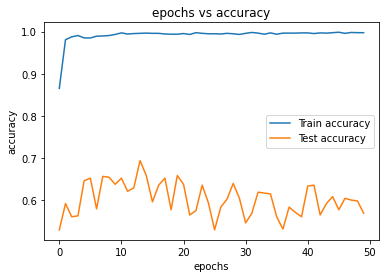

In [239]:
plt.plot(train_accuracy_history, label='Train accuracy')
plt.plot(test_accuracy_history, label='Test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("epochs vs accuracy")

Text(0.5, 1.0, 'epochs vs loss')

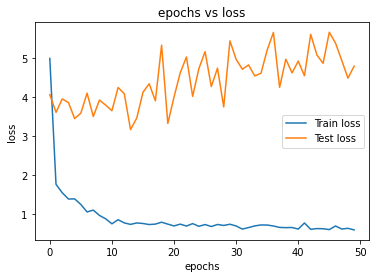

In [240]:
plt.plot(train_loss_history, label='Train loss')
plt.plot(test_loss_history, label='Test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("epochs vs loss")